In [122]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import h5py

sns.set_style('whitegrid')

sns.set_context('notebook')

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
%load_ext autoreload
%autoreload 2

root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx, triplot, plotly_3d, load_d, dinpca, dbhat, plotly_3d
from embed import proj_, lazy_embed
from reparameterization import v0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo
import pandas as pd
pyo.init_notebook_mode()
from matplotlib.lines import Line2D    
from utils import CDICT_M

In [124]:
dev='cuda'

In [125]:
def num_deriv(yhs, center=5, win=5):
    # yhs = [num_models, num_times, num_samples, num_classes]
    yhs = yhs[:, center-win:center+win, :,:]
    tan = (yhs[:, center+win-1:0:-1, :, :] - yhs[:, 1:, :, :])[:, :win-1, :]

    tan = tan/np.arange((win-1)*2,0,-2)[None, :,None,None]
    return tan.sum(1) / (win-1)

def lin_interp(init, tan, ts):
    pts = np.stack([init+t*tan for t in ts])
    pts = np.abs(pts)
    pts /= pts.sum(-1, keepdims=True)
    return pts

def avg_v0(p, q, center=0, win=5):
    # p is a fixed point, shape=(num_models, 1, num_samples, num_classes)
    # q.shape = (num_models, num_t, num_samples, num_classes)
    vt = np.stack([v0(p, q[:, center+i, :]) for i in range(1, win)])
    return vt.mean(0)


def embed_(dists, ne):
    dmean = dists.mean(0)
    l = np.eye(dists.shape[0]) - 1.0 / dists.shape[0]
    dists = -l @ dists @ l / 2
    r = proj_(dists, len(dists), ne)
    return r

In [203]:
all_f = glob.glob('/home/ubuntu/ext_vol/inpca/results/models/loaded/*.p')
fs = [f'/home/ubuntu/ext_vol/inpca/results/models/loaded/{{"seed":{s},"bseed":-1,"aug":"none","m":"allcnn","bn":true,"drop":0.0,"opt":"{opt}","bs":200,"lr":0.1,"wd":0.0,"corner":"normal","interp":false}}.p' for s in range(42, 52) for opt in ['sgd', 'sgdn']]
# fs = np.random.permutation(all_f)[:10]
d = load_d(fs, avg_err=True)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.85s/it]


In [204]:
g = th.load('/home/ubuntu/ext_vol/inpca/results/models/loaded/{"seed":0,"bseed":-1,"aug":"na","m":"geodesic","bn":"na","drop":"na","opt":"geodesic","bs":"na","lr":"na","wd":"na","interp":false}.p')

In [205]:
geod = np.exp(np.vstack(g.yh))[::2, :, :]
p0 = geod[0, :]
ps = geod[-1, :]

In [206]:
it = 10
et = 10

In [207]:
yhs = np.stack(d.yh)
if (yhs<0).any():
    yhs = np.exp(yhs)

In [208]:
cols = ["seed", "m", "opt", "bs", "aug", "lr", "wd"]
# tmax=62
yhs_ = np.stack([yhs[list(ii[:10])+list(ii[-10:]), :] for ii in d.groupby(cols).indices.values()])
nmodels, T, _, _ = yhs_.shape

In [189]:
# initial v

vinit = avg_v0(p=np.tile(p0[None, :, :], [nmodels, 1, 1]),
               q=yhs_, center=0, win=5
              )
vinit_avg = vinit.mean(0)
init_tan = lin_interp(p0, vinit_avg, ts=np.arange(it)).squeeze()

vend = avg_v0(p=np.tile(ps[None, :, :], [nmodels, 1, 1]),
               q=yhs_, center=T-5, win=5
              )
vend_avg = vend.mean(0)
end_tan = lin_interp(ps, -vend_avg, ts=np.arange(et)).squeeze()

In [209]:
# Han's method
init_tan = num_deriv(yhs_,5, 5)
init_tan = lin_interp(p0, init_tan.mean(0), ts=np.arange(it))

end_tan = num_deriv(yhs_, yhs_.shape[1]-5, 2)
end_tan = lin_interp(ps, -end_tan.mean(0), ts=np.arange(et))

In [210]:
all_points = th.tensor(np.vstack([init_tan, geod, end_tan]))

In [211]:
dists = dbhat(all_points, all_points, chunks=200, dev=dev)
dmean = dists.mean(0)

In [212]:
r = embed_(dists, 3)

Projecting


In [213]:
pts = lazy_embed(new_pts=th.tensor(yhs),
                 ps=all_points.float(), 
                 evals=r['e'], evecs=r['v'], d_mean=dmean, chunks=500, dev=dev)

In [214]:
xp = np.vstack([r['xp'], pts])
r['xp'] = xp

In [215]:
didx = pd.DataFrame(['init']*len(init_tan) + ['geod']*len(geod) + ['end']*len(end_tan)+['original']*len(pts),
                    columns=['name'])
didx['t'] = list(np.arange(it))+list(np.arange(50)) + list(np.arange(et))+list(np.arange(len(d)))

In [216]:
plotly_3d(didx, r, color='name', cols=['name','t'], discrete_c=True, colorscale='Set1')

{'init': '#e41a1c', 'geod': '#377eb8', 'end': '#4daf4a', 'original': '#984ea3'}
[ 8.07530571e+00 -6.05185920e-01  1.78847064e-01  5.19668674e-02
 -5.07665659e-03  4.62683006e-03 -3.84186384e-04 -5.73545897e-05
 -9.34475076e-07]


In [217]:
rel_error = []
dtrue = dbhat(th.tensor(yhs), th.tensor(yhs), chunks=50,dev=dev)
rtrue = embed_(dtrue, 3)
for i in range(1, 9):
    dd = dinpca(th.tensor(r['xp'][-len(d):, :i]), sign=th.tensor(np.sign(r['e'][:i])).double(), dev=dev).cpu().numpy()
    ddrtrue = dinpca(th.tensor(rtrue['xp'][-len(d):, :i]), sign=th.tensor(np.sign(rtrue['e'][:i])).double(),dev=dev).cpu().numpy()
    rel_error.append(((np.abs(dd - dtrue)).sum() / dtrue.sum(), (np.abs(ddrtrue - dtrue)).sum() / dtrue.sum()))
rel_err = pd.DataFrame(rel_error, columns=['tangent_embedding', 'original_embedding'])

RuntimeError: CUDA out of memory. Tried to allocate 13.38 GiB (GPU 0; 22.20 GiB total capacity; 8.46 GiB already allocated; 7.20 GiB free; 13.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [200]:
rel_err = rel_err.reset_index().melt(id_vars='index', value_vars=['tangent_embedding', 'original_embedding'])

<AxesSubplot:xlabel='index', ylabel='value'>

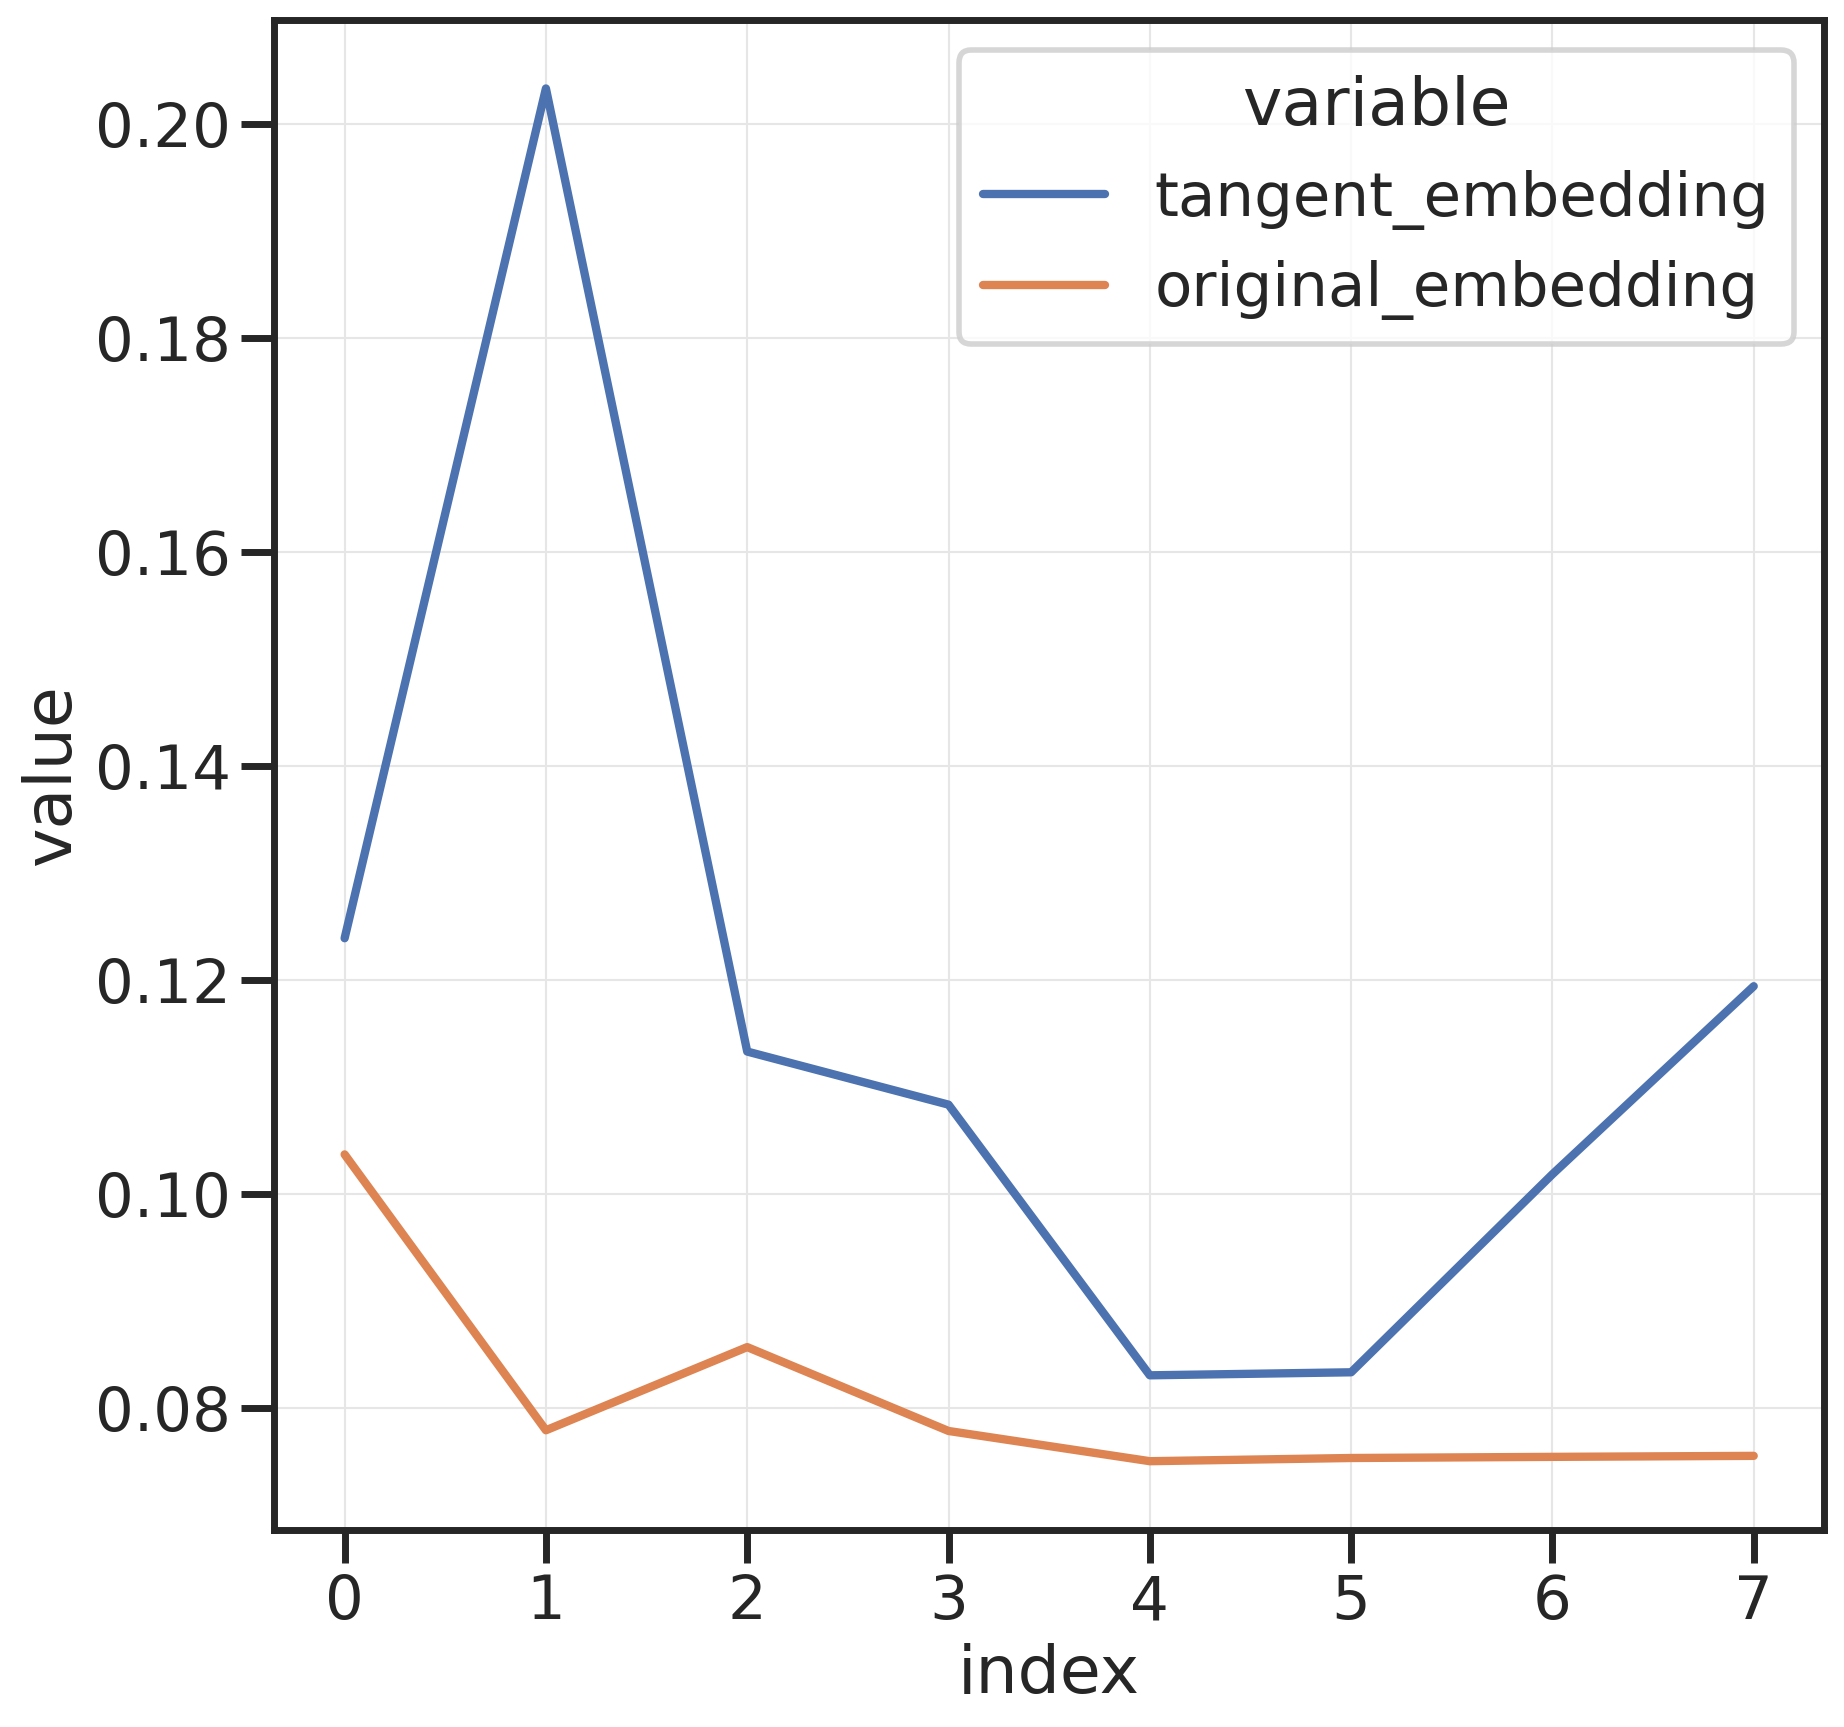

In [85]:
sns.lineplot(data=rel_err, x='index', y='value', hue='variable')

<AxesSubplot:xlabel='index', ylabel='value'>

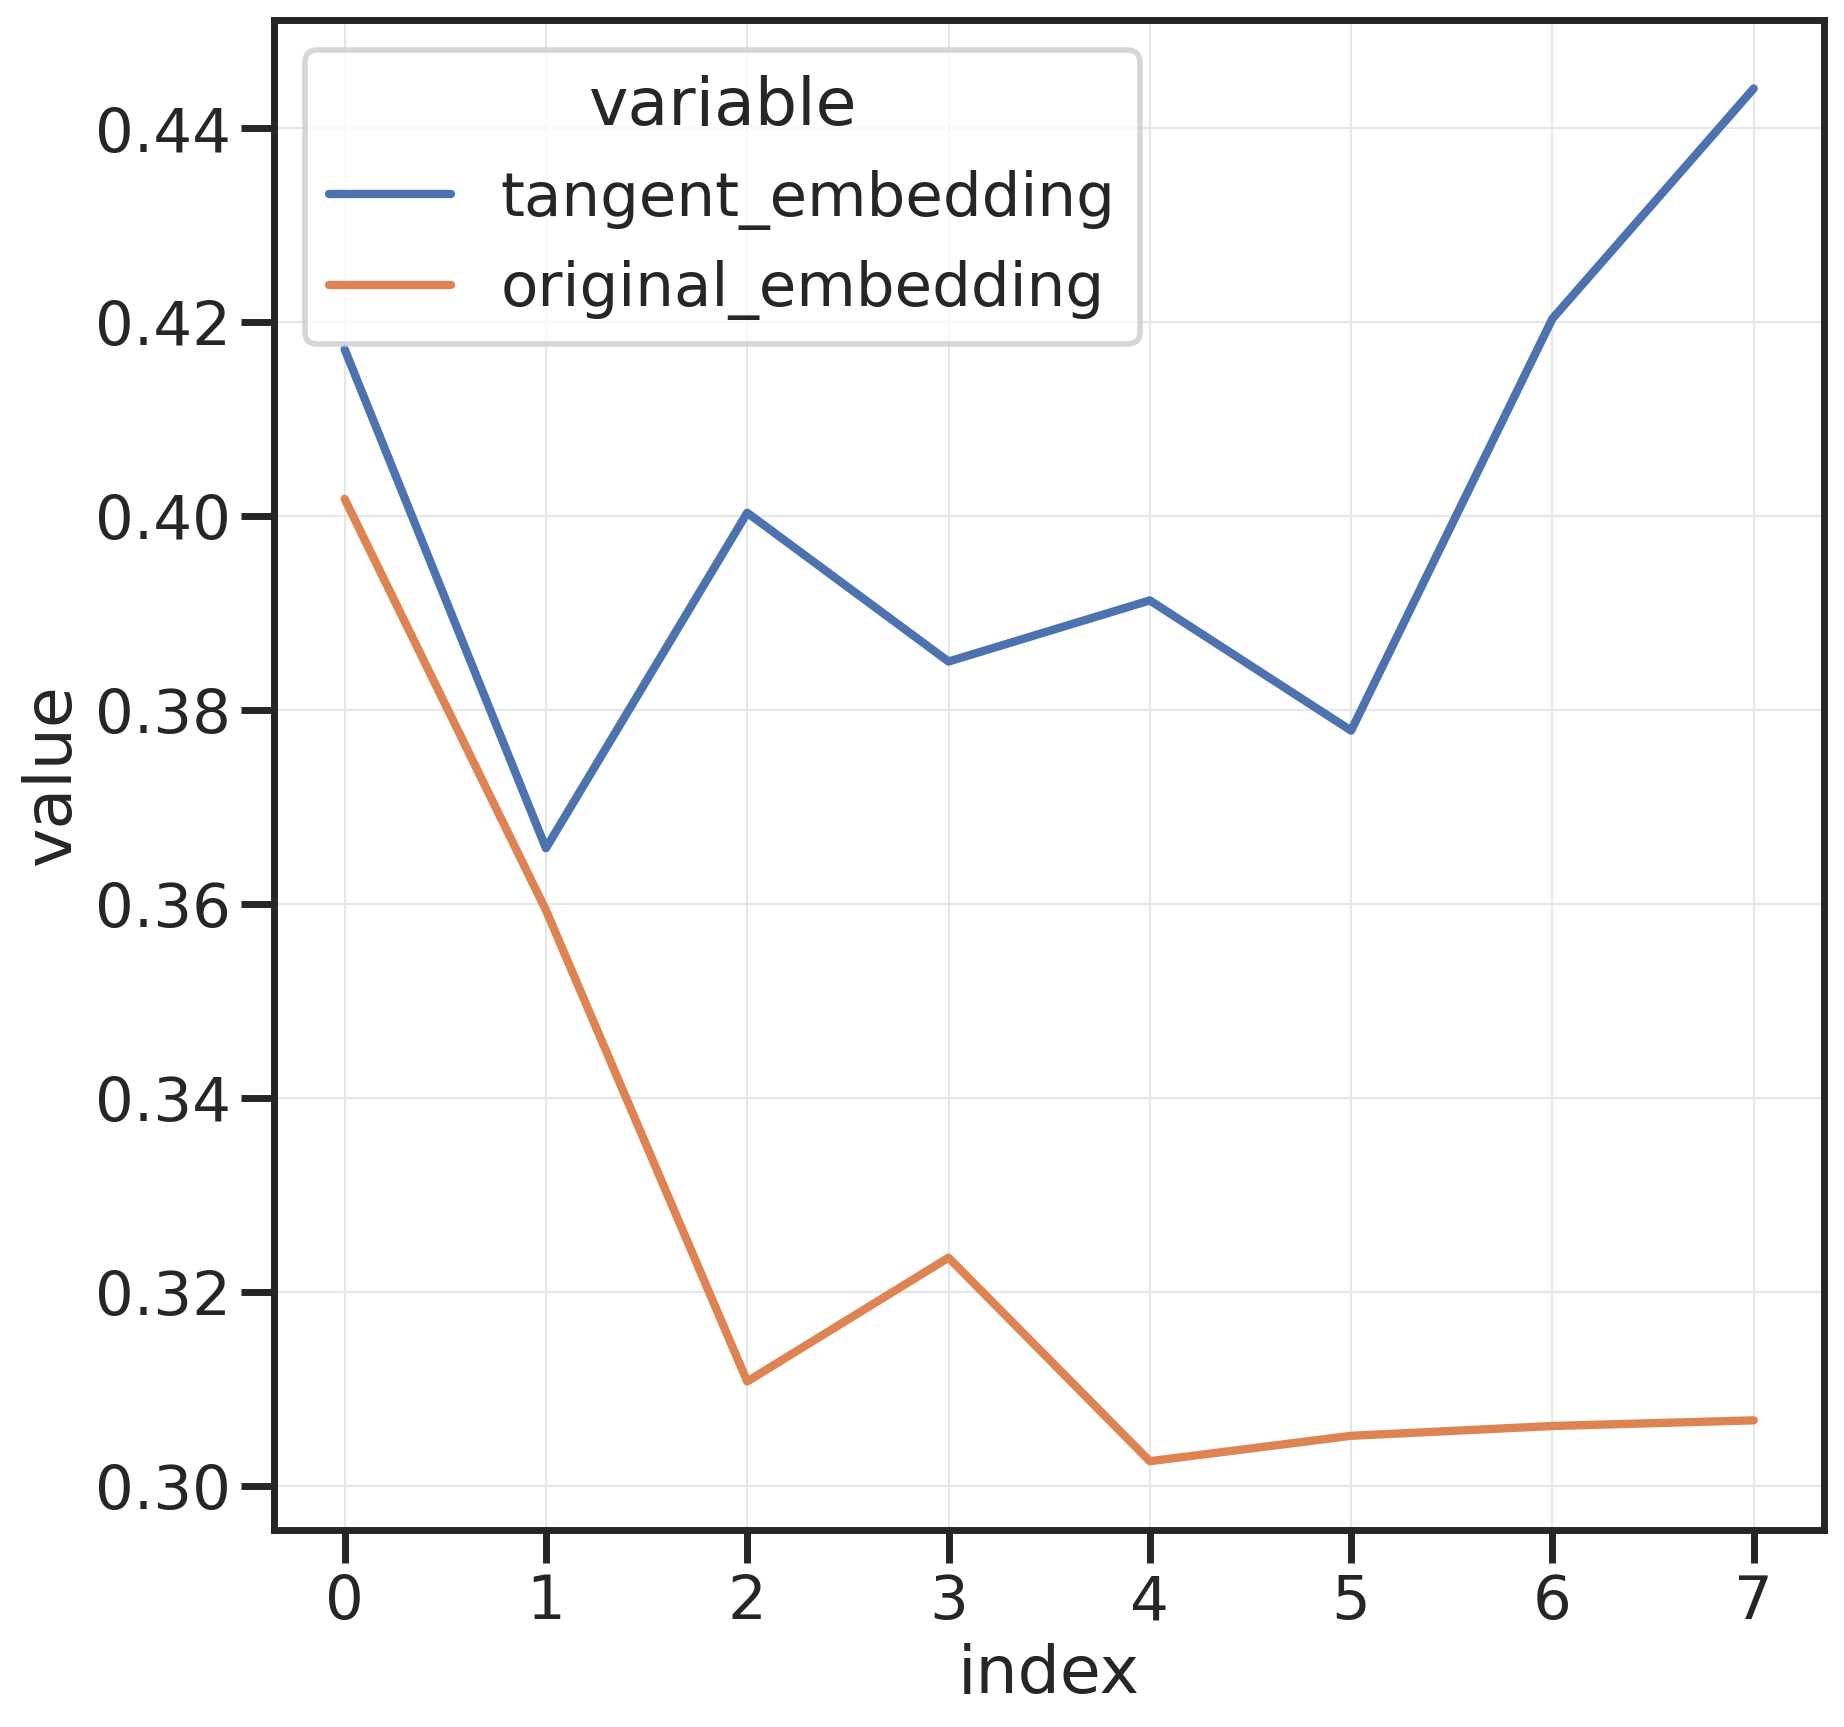

In [142]:
sns.lineplot(data=rel_err, x='index', y='value', hue='variable')

<AxesSubplot:xlabel='index', ylabel='value'>

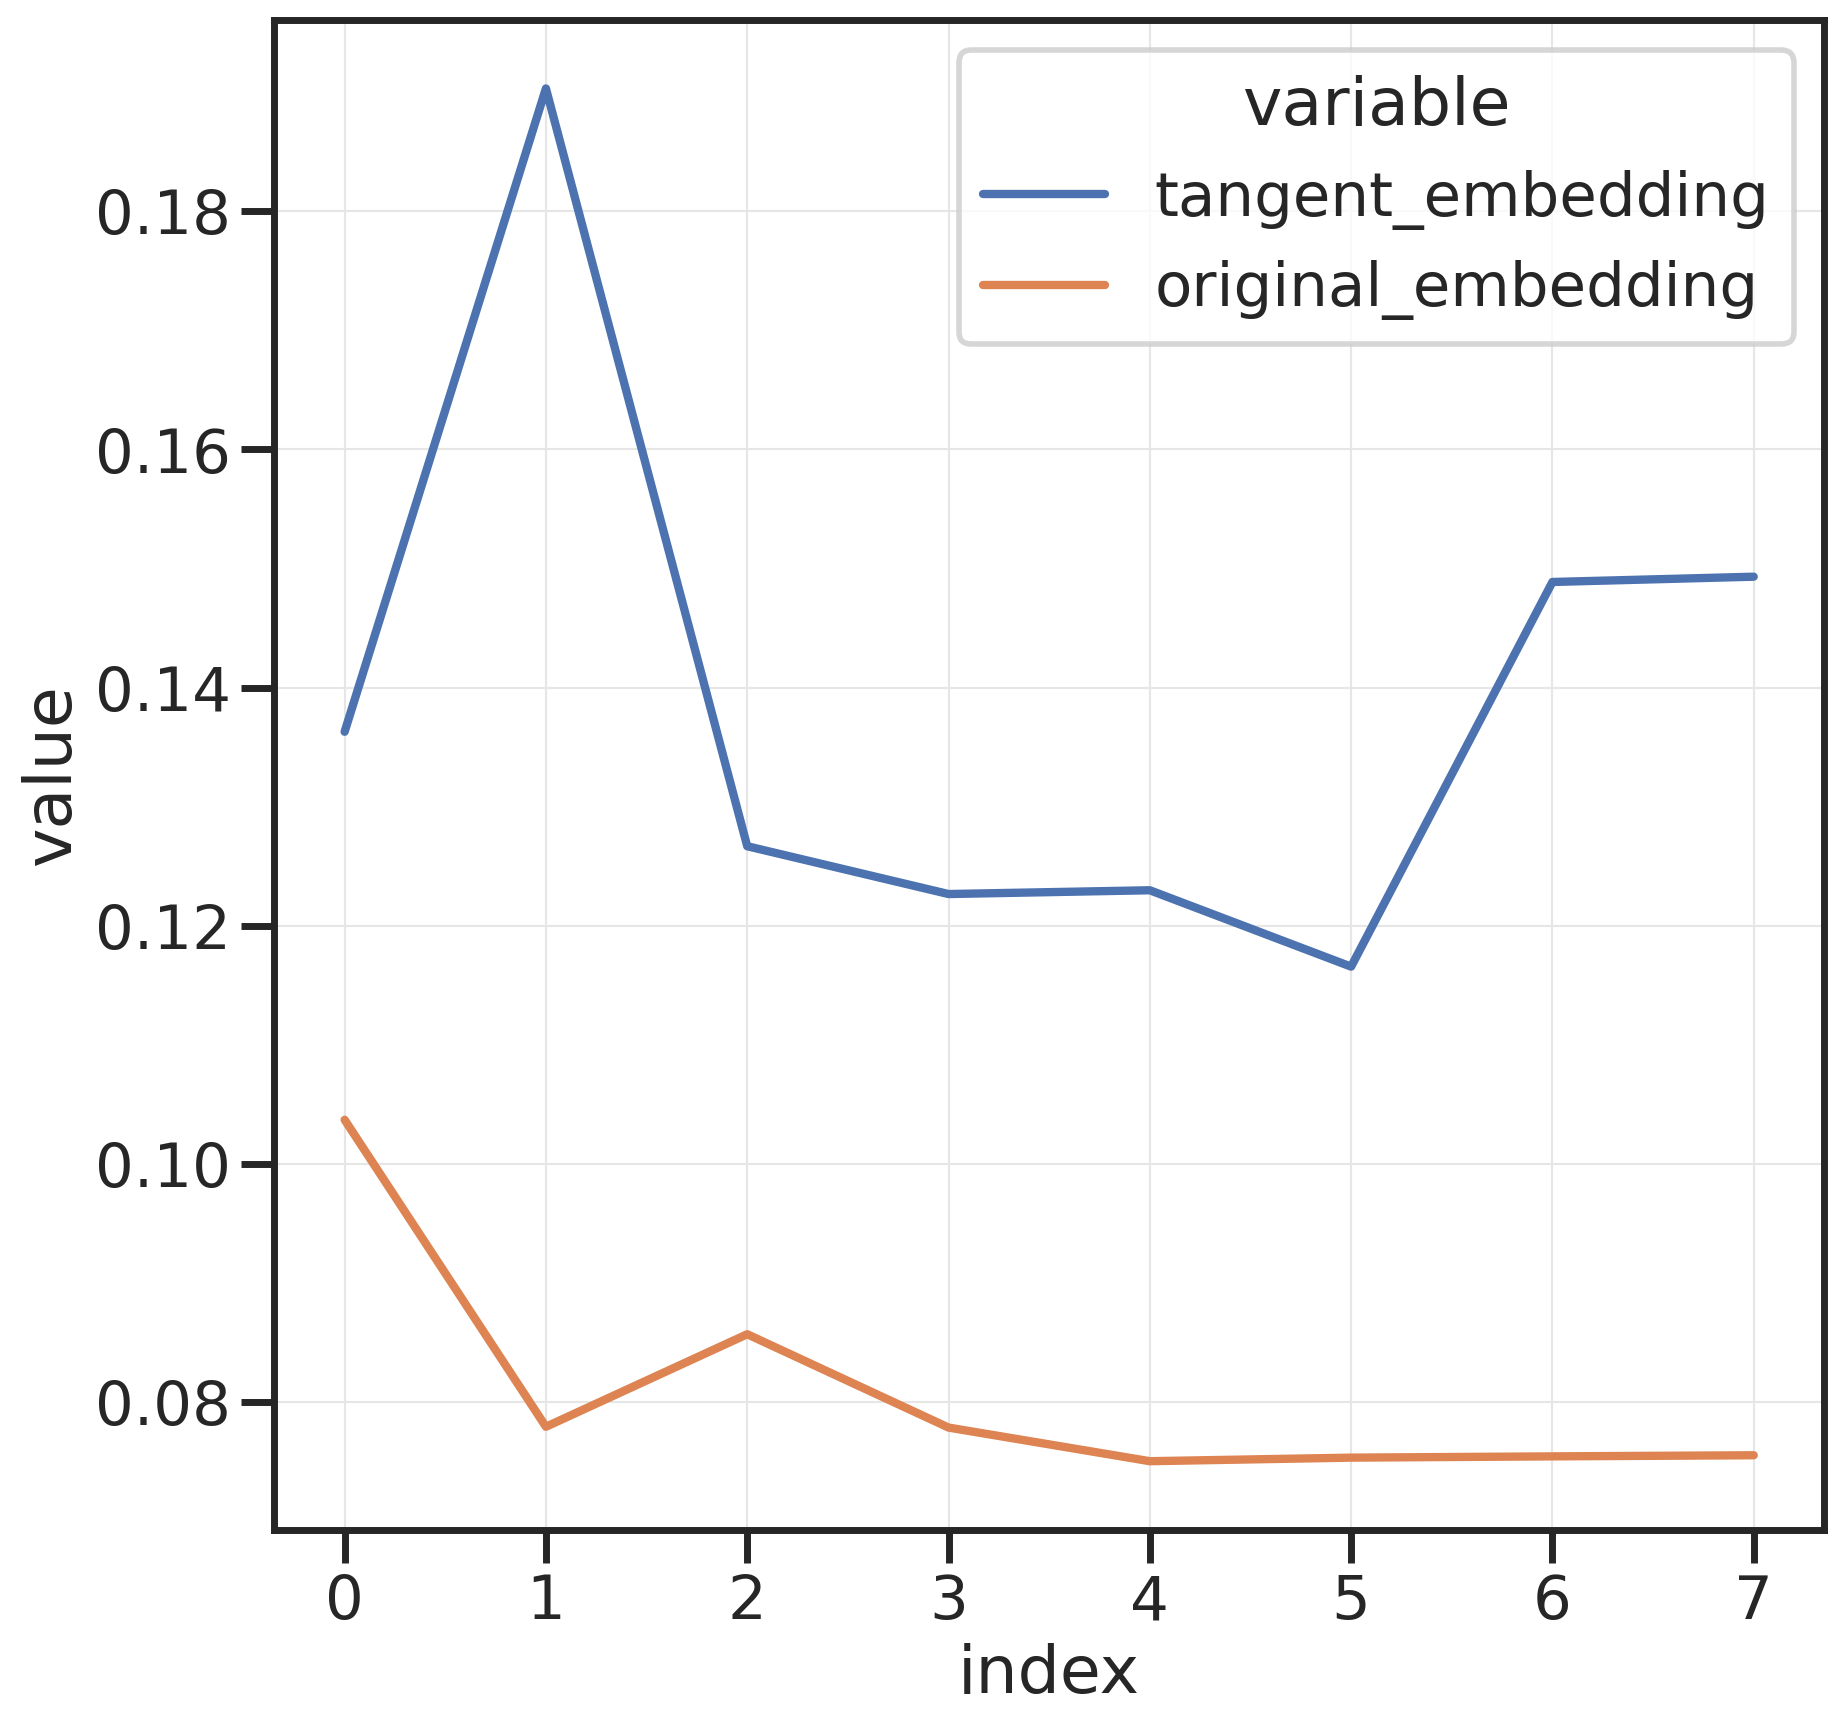

In [201]:
sns.lineplot(data=rel_err, x='index', y='value', hue='variable')